In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages, get_6montages
import mne
from scipy import signal as sig
import ruptures as rpt

import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
training_folder = "../../shared_data/training_mini"

In [4]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 
# Importiere EKG-Dateien, zugehörige Diagnose, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz)

100	 Dateien wurden geladen.


In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import joblib
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# Pre-Processing

Alle Montagen wurden berechnet:  True
Montagen:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
Signal Dimension:  (3, 299250)
0 Fp1-F3
0.0006385289600207524
1 Fp2-F4
0
2 C3-P3
-0.0006385289600207524


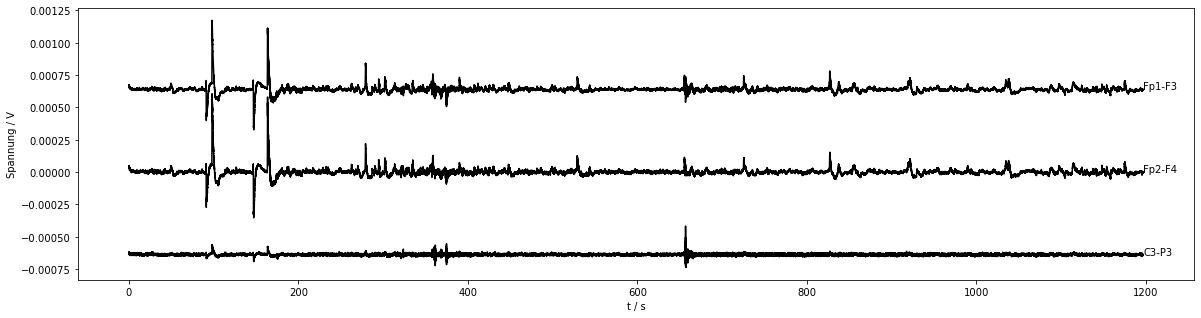

In [44]:
# Necessary to install spkit
import spkit as sp
import pywt
from sklearn.ensemble import RandomForestClassifier

idx_record = 40

new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("Alle Montagen wurden berechnet: ", not is_missing)
print("Montagen: ",new_montage)
print("Signal Dimension: ", new_data.shape)

fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    print(i, _montage)
    print(_off_sets[i])
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()


In [9]:
np.shape(labels)

(8498,)

In [7]:
np.shape(features)

(25494, 15)

In [15]:
np.shape(a)

(2, 3, 15)

In [33]:
a = [np.zeros(5),np.zeros(5)]
b = [np.zeros(5),np.zeros(5)]
c = [np.zeros(5),np.zeros(5)]

In [73]:
[1,2,3]+[4,5,6]

[1, 2, 3, 4, 5, 6]

In [74]:
feats = []
for i in range(len(m[0])):
    a = m[0][i].flatten().tolist()
    b = m[1][i].flatten().tolist()
    c = m[2][i].flatten().tolist()
    feats.append(a+b+c)

In [75]:
feats

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [49]:
len(m)

3

In [48]:
m[0][1].flatten().tolist()

[0.0, 0.0, 0.0, 0.0, 0.0]

In [36]:
m = [a,b,c]

In [89]:
import numpy as np
from wettbewerb import load_references, get_3montages, get_6montages
import pywt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

N_samples = 2000 # Numeber of samples per division
# Decompose the wave
wavelet = 'db4'
scaler = StandardScaler()
normalization = True
features = []
for i,_id in enumerate(ids):
    _montage, _montage_data, _is_missing = get_6montages(channels[i], data[i])
    _fs = sampling_frequencies[i]
    features_per_id = []

    for j, signal_name in enumerate(_montage):
        features_per_mont = []
        signal = _montage_data[j]
        # Notch-Filter to compensate net frequency of 50 Hz
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Bandpassfilter between 0.5Hz and 70Hz to filter out noise
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        # Defining number of divisions for signal
        N_div = len(signal_filter)//N_samples
        # Normalizing data
        norm_montage_data = scaler.fit_transform(signal_filter.reshape(-1,1)).reshape(1,-1)[0]
    
        for i in range(N_div):
            features_per_div = np.zeros(5)
            montage_array = norm_montage_data[i*N_samples:(i+1)*N_samples]
            ca4, cd4, cd3, cd2, cd1 = pywt.wavedec(montage_array, wavelet, level=4)
            montage_dwt = [ca4, cd4, cd3, cd2, cd1]
            
            for w in range(len(montage_dwt)):
                features_per_div[w] = np.sum(np.abs(np.diff(montage_dwt[w])))/len(montage_dwt[w]) 
                
            features_per_mont.append(features_per_div)
            
        features_per_id.append(features_per_mont)
        
    for n_piece in range(len(features_per_mont)):
        list_montages = []
        for n_montage in range(len(features_per_id)):
            list_montages += features_per_id[n_montage][n_piece].flatten().tolist()
        features.append(list_montages)


labels = []
for i,_id in enumerate(ids):
    if eeg_labels[i][0]:
        onset = eeg_labels[i][1]
        offset = eeg_labels[i][2]
        sample_freq = sampling_frequencies[i]
        total_time = len(data[i][1])/sample_freq
        N_div = len(data[i][1])//N_samples
        for num in range(N_div):
            if (((total_time/N_div)*(num) <= onset) and ((total_time/N_div)*(num+1) > onset)) or (((total_time/N_div)*(num) >= onset) and ((total_time/N_div)*(num) < offset)):
                labels.append([1])
            else:
                labels.append([0])
    else:
        N_div = len(data[i][1])//N_samples
        for num in range(N_div):
            labels.append([0])
labels = np.reshape(labels, (1,-1))[0]

rf_classifier = RandomForestClassifier(
    n_estimators=300,  # Number of trees in the forest
    max_features="sqrt",  # Number of features to consider at each split
    max_depth=10,  # Maximum depth of each tree
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
)

oversample = SMOTE()
features_smote, labels_smote = oversample.fit_resample(features,labels)
rf_classifier.fit(features_smote, labels_smote)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=300)

In [62]:
for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        # Berechne Montage
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        time_ax = np.arange(_montage_data.shape[1])/_fs
        for j, signal_name in enumerate(_montage):
            # Get montage of the signal
            signal = _montage_data[j]
            
            """ Preprocessing"""
            # Notch-Filter to atenuate 50 Hz frequency from the power supply
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # Bandpass filter between 0.5 Hz and 70Hz to filter signal
            # In general, the EEG of most seizures have frequencies between 3 and 29 Hz (Gotman,1982)
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            # Filter out artifacts from EEG signal using ATAR (Wavelet Package Decomposition, and Automatic and Tuneble Artifacts Removal Algorithm)
            signal_atar = sp.eeg.ATAR(signal_filter,
                                      wv='db4',
                                      winsize=128,
                                      beta=0.8,
                                      thr_method='ipr',
                                      OptMode='soft', 
                                      verbose=1)
            

* Class Imbalance Issues

* Downsampling

* Apply Notch-Filter to filter out 50 Hz power line interference

* Filter out artifacts

* Normalizing the data (-1,1)

In [30]:
# Código da Sophia (Features)
import numpy as np
import pywt

scales = range(1,128)
waveletname = 'morl'

feature = np.zeros((len(ids),(36))) 
for i,_id in enumerate(ids):
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], data[i])
    _fs = sampling_frequencies[i]
    id_feature = np.zeros(36)
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Notch-Filter to compensate net frequency of 50 Hz
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Bandpassfilter between 0.5Hz and 70Hz to filter out noise
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        # Continuous Wavelet Transfrmation
        coeff, freq = pywt.cwt(signal_filter, scales, waveletname, 1)
        print(np.shape(coeff))
        if i == 30:
              print(coeff)

    #feature[i,:] = id_feature

labels = np.array(eeg_labels, dtype=int)[:,0]

NameError: name 'ids' is not defined

In [3]:
# -*- coding: utf-8 -*-

import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt
import json
import pywt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE

import numpy as np
from wettbewerb import load_references, get_3montages, get_6montages
import pywt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

number_montages = 6
N_samples = 2000 # Number of samples per division
# Decompose the wave
wavelet = 'db4'
scaler = StandardScaler()
new_signal = []

mont1_signal = []
mont2_signal = []
mont3_signal = []
whole_mont = [mont1_signal,mont2_signal,mont3_signal]
for i,_id in enumerate(ids):
    
    if number_montages == 3:
        _montage, _montage_data, _is_missing = get_6montages(channels[i], data[i])
    else:
        _montage, _montage_data, _is_missing = get_3montages(channels[i], data[i])
        
    _fs = sampling_frequencies[i]
    features_per_id = []

    for j, signal_name in enumerate(_montage):
        signal = _montage_data[j]
        # Notch-Filter to compensate net frequency of 50 Hz
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Bandpassfilter between 0.5Hz and 70Hz to filter out noise
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        # Defining number of divisions for signal
        N_div = len(signal_filter)//N_samples
        # Normalizing data
        norm_montage_data = scaler.fit_transform(signal_filter.reshape(-1,1)).reshape(1,-1)[0]
    
        for i in range(N_div):
            montage_array = norm_montage_data[i*N_samples:(i+1)*N_samples]
            whole_mont[j].append(montage_array)


labels = []
for i,_id in enumerate(ids):
    if eeg_labels[i][0]:
        onset = eeg_labels[i][1]
        offset = eeg_labels[i][2]
        sample_freq = sampling_frequencies[i]
        total_time = len(data[i][1])/sample_freq
        N_div = len(data[i][1])//N_samples
        for num in range(N_div):
            if (((total_time/N_div)*(num) <= onset) and ((total_time/N_div)*(num+1) > onset)) or (((total_time/N_div)*(num) >= onset) and ((total_time/N_div)*(num) < offset)):
                labels.append([1])
            else:
                labels.append([0])
    else:
        N_div = len(data[i][1])//N_samples
        for num in range(N_div):
            labels.append([0])
labels = np.reshape(labels, (1,-1))[0]

In [2]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references('../../shared_data/training_mini/') 
# Importiere EKG-Dateien, zugehörige Diagnose, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz)

100	 Dateien wurden geladen.


In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
oversample = SMOTE()
undersample = RandomUnderSampler()

mont1_signal, labels1 = undersample.fit_resample(whole_mont[0],labels)
mont2_signal, labels2 = undersample.fit_resample(whole_mont[1],labels)
mont3_signal, labels3 = undersample.fit_resample(whole_mont[2],labels)

In [17]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([7792,  706]))

In [18]:
np.unique(labels1, return_counts=True)

(array([0, 1]), array([706, 706]))

In [19]:
labels1

array([0, 0, 0, ..., 1, 1, 1])

In [20]:
labels2

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
labels3

array([0, 0, 0, ..., 1, 1, 1])

In [23]:
for i in range(len(labels1)):
    if labels2[i] != labels2[i]:
        print("Diferente")